In [1]:
using Pkg; Pkg.instantiate(); Pkg.precompile()

Precompiling project...


In [2]:
using Random; Random.seed!(2020);

# What is the average grain size?

We have a Micro-CT image of a rock sample such as the *Ketton* image provided by the [PERM Research Group at Imperial College London](http://www.imperial.ac.uk/earth-science/research/research-groups/perm/research/pore-scale-modelling/micro-ct-images-and-networks), and wish to estimate the average grain size within this sample. The average grain size can be an important parameter for subsurface characterization, but assigning a single value for the sample objectively is not always trivial.

<img src="https://raw.githubusercontent.com/JuliaEarth/GeoStatsImages.jl/master/src/data/Ketton.png" width="30%">
<div style="text-align: center"> <b>Image credit:</b> <i>PERM at Imperial College London</i> </div>

**Problem statement**:

Estimate the average grain size (e.g. average grain radius) in the rock sample.

*Can we do any better than visual estimation?*

In [3]:
using GeoStats
using GeoStatsImages
using Plots; gr(c=:cividis, ms=2)

𝒦 = geostatsimage("Ketton")

256×256×256 RegularGrid{Float64,3}
  variables
    └─grain (Float64)

## Two-point statistics

We will solve this problem by estimating the probability of two locations $\newcommand{\u}{\mathbf{u}}\newcommand{\v}{\mathbf{v}}\newcommand{\R}{\mathbb{R}} \u,\v\in\R^3$ to be on a grain, and by understanding how this probability changes as the distance $h=||\u-\v||$ between these locations is made larger.

Consider two Bernoulli random variables $Z_\u$ and $Z_\v$ that indicate *grain* with probability $p$ and *non-grain* with probability $1-p$ at locations $\u$ and $\v$, respectively. The variogram between these locations is defined as:

$$
\newcommand{\E}{\mathbb{E}}
\gamma(h) = \frac{1}{2} \E\left[(Z_\u - Z_\v)^2\right] = \frac{1}{2}\left(\E\left[Z_\u^2\right] + \E\left[Z_\v^2\right] - 2\E\left[Z_\u Z_\v\right]\right)
$$

We can derive the expectations:

- $\E\left[Z_\u^2\right] = \E[Z_\u Z_\u] = Pr(Z_\u=1, Z_\u=1) = Pr(Z_\u=1)$
- $\E[Z_\u Z_\v] = Pr(Z_\u=1, Z_\v=1) = Pr(Z_\u=1)Pr(Z_\v=1 | Z_\u=1)$
- $\E\left[Z_\v^2\right] = Pr(Z_\v=1)$ (exactly like above)

and use the fact that $Pr(Z_\u=1) = Pr(Z_\v=1) = p$ to rewrite the variogram as:

$$
\gamma(h) = p\cdot\big(1 - Pr(Z_\v=1 | Z_\u=1)\big) = p\cdot Pr(Z_\v=0|Z_\u=1)
$$

or alternatively:

$$
Pr(Z_\v=0 | Z_\u=1) = \frac{\gamma(h)}{p}
$$

This last equation shows that we can calculate the probability that a location $\v$ is *non-grain* given that a location $\u$ is *grain* (left-hand-side) provided that we can efficiently estimate the variogram $\gamma(h)$ and the marginal probability $p$ from spatial data (right-hand-side).

### Partition variograms

Efficient parallel algorithms for variogram estimation do exist [Hoffimann & Zadrozny 2019](https://www.sciencedirect.com/science/article/pii/S0098300419302936). Here, we consider 1M samples from the Ketton rock to demonstrate GeoStats.jl's computational performance:

In [4]:
𝒮 = sample(𝒦, 1_000_000, replace=false)

1000000 DataView{Float64,3}
  variables
    └─grain (Float64)

Due to compaction and other physical processes, grains are ellipsoids with major and minor axes. We would like to characterize these axes for different sections (or planes) of the Ketton rock. For example, we can consider planes that are normal to the vertical direction:

In [5]:
𝒫 = partition(𝒮, PlanePartitioner((0.,0.,1.)))

plot(𝒫[1])
plot!(𝒫[2])
plot!(𝒫[3])

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/juliohm/.julia/packages/Plots/VA7Vx/src/backends/gr.jl:493


and efficiently estimate the variogram on these planes:

In [6]:
@time EmpiricalVariogram(𝒫, :grain)

 15.345926 seconds (1.85 G allocations: 32.264 GiB, 31.36% gc time)


EmpiricalVariogram
  distance: Distances.Euclidean(0.0)
  abscissa: (0.9015611460128481, 35.16088469450108)
  ordinate: (0.01864478966366427, 0.1130675764467619)
  N° pairs: 107545403


These two steps can be performed together using a `PlanarVariogram`, where the first argument is the normal direction to the planes of interest:

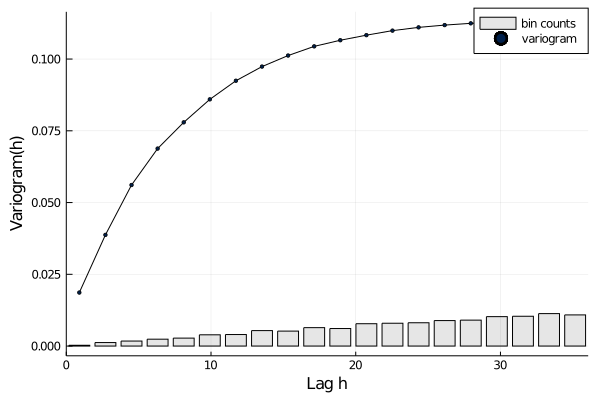

In [7]:
γₑ = PlanarVariogram((0.,0.,1.), 𝒮, :grain)

plot(γₑ)

In order to evaluate the variogram at any distance (or lag), we fit a theoretical variogram model:

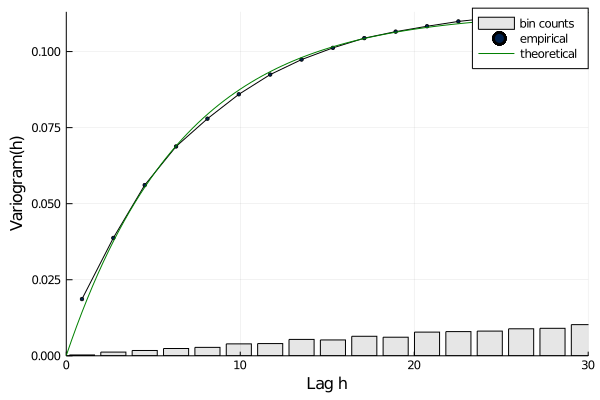

In [8]:
γₜ = fit(ExponentialVariogram, γₑ)

plot(γₑ, label="empirical")
plot!(γₜ, c=:green, maxlag=30., label="theoretical")

Finally, we estimate the marginal probability $p$ using the proportion of *grain* in the rock, and scale our variogram accordingly:

In [9]:
p = mean(𝒮[:grain])

γₚ = (1/p) * γₜ

ScaledVariogram{Float64,Distances.Euclidean,ExponentialVariogram{Float64,Distances.Euclidean},Float64}(1.1455422939942654, ExponentialVariogram{Float64,Distances.Euclidean}
  range: Float64 20.115404723053793
  sill: Float64 0.11306757644676188
  nugget: Float64 0.00010988657346936012
  distance: Distances.Euclidean
)

### Probability versus distance

The scaled variogram $\gamma_p(h)$ is the probability $Pr(Z_\v=0|Z_\u=1)$ as a function of the distance $h = ||\u-\v||$:

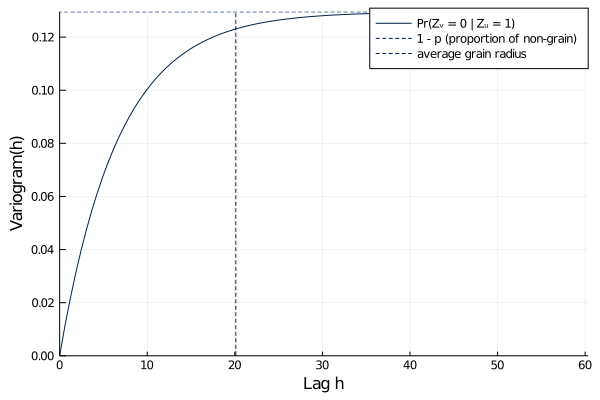

In [10]:
plot(γₚ, label="Pr(Zᵥ = 0 | Zᵤ = 1)")
hline!([sill(γₚ)], ls=:dash, label="1 - p (proportion of non-grain)")
vline!([range(γₚ)], ls=:dash, label="average grain radius")

The probability levels out at some positive distance (known as the variogram range), after which the chance of encountering a *non-grain* at location $\v$ given a *grain* at location $\u$ is simply the marginal probability of *non-grain* $1-p$ (i.e. the variogram sill):

In [11]:
1 - p

0.12705100000000003

Additionally, we define the "average grain radius" on the planes of interest as the variogram range.

### Average grain shape

We can create a function to compute the average grain radius for any set of planes given a normal direction:

In [12]:
function radius(normal)
    γₑ = PlanarVariogram(normal, 𝒮, :grain)
    γₜ = fit(ExponentialVariogram, γₑ)
    p = mean(𝒮[:grain])
    range((1/p) * γₜ)
end

for normal in [(1.,0.,0.), (0.,1.,0.), (0.,0.,1.)]
    println(normal, " → ", radius(normal))
end

(1.0, 0.0, 0.0) → 18.378153943606204
(0.0, 1.0, 0.0) → 18.082732918868874
(0.0, 0.0, 1.0) → 20.115404723053793


We notice that the average grain radius is larger on horizontal sections of the rock compared with vertical sections. To visualize this anisotropy, we choose a set of vertical planes and estimate the variogram for all directions on these planes:

In [13]:
γθ = @time EmpiricalVarioplane(𝒮, :grain, maxlag=30., normal=(1.,0.,0.))

110.562304 seconds (2.52 G allocations: 98.911 GiB, 13.81% gc time)


EmpiricalVarioplane
  N° pairs
  └─0.00° → 1678838
  └─3.67° → 1361549
  └─7.35° → 1370596
  └─11.02° → 1386480
  └─14.69° → 1374232
  ⋮
  └─165.31° → 1374745
  └─168.98° → 1382799
  └─172.65° → 1373066
  └─176.33° → 1364864
  └─180.00° → 1678838

The following plot depicts the "average grain shape" on vertical sections of the rock:

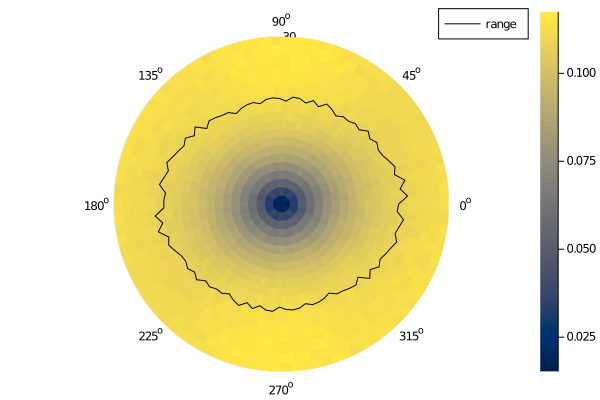

┌ Warning: Right now only the maximum value of y (r) is taken into account.
└ @ Plots /home/juliohm/.julia/packages/Plots/VA7Vx/src/backends/gr.jl:1750


In [14]:
plot(γθ, model=ExponentialVariogram)

## Remarks

- Variograms can be useful to efficiently estimate two-point spatial probabilities.
- We've shown that the variogram range represents the "average grain radius".
- GeoStats.jl provides variogram estimators that can handle more than 1M points.
- For more details, please check:
  - *Hoffimann & Zadrozny. 2019.* [Efficient variography with partition variograms](https://www.sciencedirect.com/science/article/pii/S0098300419302936)